In [11]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import mne
import pathlib

### Interface with data

In [12]:
data_dir = pathlib.Path("../../data/")
assert data_dir.is_dir()

data_dir_healthy = data_dir / "healthy_controls/preprocessed"
assert data_dir_healthy.is_dir()

data_dir_chronic_pain = data_dir / "chronic_pain_patients"
assert data_dir_chronic_pain.is_dir()

In [13]:
eeg_files_all = list(data_dir.rglob("*.vhdr"))

eeg_files_raw = [f for f in eeg_files_all if not "preprocessed" in str(f)]
eeg_files_preprocessed = [f for f in eeg_files_all if "preprocessed" in str(f)]

eeg_files_healthy = list(data_dir_healthy.rglob("*.vhdr"))
eeg_files_chronic_pain = [f for f in eeg_files_preprocessed if "chronic_pain_patients" in str(f)]


### Analyze the subject data

#### Load clinical data

In [14]:
f_subj = data_dir / "clinical_data_updated_2020-08-04.ods"
assert f_subj.is_file()

In [15]:
df_subj_chronic_pain = pd.read_excel(f_subj, sheet_name=0, engine="odf", skiprows=1)
df_subj_healthy = pd.read_excel(f_subj, sheet_name=1, engine="odf", skiprows=0)

df_subj = pd.concat([df_subj_chronic_pain, df_subj_healthy])
df_subj["Age(years)"] = df_subj["Age(years)"].fillna(df_subj["Age (years)"])

print(f"# recorded subjects:      {len(df_subj_healthy)+len(df_subj_chronic_pain)}")
print(f"# raw eeg files:          {len(eeg_files_raw)}")
print(f"# preprocessed eeg files: {len(eeg_files_preprocessed)}")

zfill_ints = lambda x:str(x).zfill(3) if type(x) else x
df_subj_chronic_pain["Subject ID"] = df_subj_chronic_pain["Subject ID"].astype(str).map(zfill_ints)
df_subj_healthy["Subject ID"] = df_subj_healthy["Subject ID"].astype(str).map(zfill_ints)
df_subj["Subject ID"] = df_subj["Subject ID"].astype(str).map(zfill_ints)

df_subj

# recorded subjects:      189
# raw eeg files:          190
# preprocessed eeg files: 189


Subject ID     Project prefix  Age(years) Sex (m/f)  Pain duration(months)  \
0        VP02  chronic_back_pain        67.0         m                  360.0   
1        VP04  chronic_back_pain        54.0         f                  120.0   
2        VP05  chronic_back_pain        64.0         f                   96.0   
3        VP07  chronic_back_pain        41.0         m                   22.0   
4        VP08  chronic_back_pain        72.0         m                  480.0   
..        ...                ...         ...       ...                    ...   
83      vpH64            various        79.0         f                    NaN   
84      vpH66            various        56.0         f                    NaN   
85      vpH67            various        54.0         m                    NaN   
86      vpH68            various        55.0         f                    NaN   
87      vpH69            various        53.0         m                    NaN   

    Avg. painIntensity (0 – 10)  Curr. Pain Intensity(0 – 10)   BDI   PDQ  \
0                           5.0                           5.0   3.0  28.0   
1                           5.0                           4.0  35.0  14.0   
2                           7.0                           5.0   7.0  16.0   
3                           6.0                           7.0  15.0  22.0   
4                           8.0                           8.0  11.0  10.0   
..                          ...                           ...   ...   ...   
83                          NaN                           NaN   NaN   NaN   
84                          NaN                           NaN   NaN   NaN   
85                          NaN                           NaN   NaN   NaN   
86                          NaN                           NaN   NaN   NaN   
87                          NaN                           NaN   NaN   NaN   

     MQS  VR-12 PCS  VR-12 MCS  PDI  Age (years)  
0    4.0        NaN        NaN  NaN          NaN  
1   31.7        NaN        NaN  NaN          NaN  
2   11.4        NaN        NaN  NaN          NaN  
3    6.1        NaN        NaN  NaN          NaN  
4    8.4        NaN        NaN  NaN          NaN  
..   ...        ...        ...  ...          ...  
83   NaN        NaN        NaN  NaN         79.0  
84   NaN        NaN        NaN  NaN         56.0  
85   NaN        NaN        NaN  NaN         54.0  
86   NaN        NaN        NaN  NaN         55.0  
87   NaN        NaN        NaN  NaN         53.0  

[189 rows x 14 columns]

In [16]:
len(df_subj)

189

array([[<Axes: title={'center': 'Age(years)'}>,
        <Axes: title={'center': 'Pain duration(months)'}>,
        <Axes: title={'center': 'Avg. painIntensity (0 – 10)'}>],
       [<Axes: title={'center': 'Curr. Pain Intensity(0 – 10)'}>,
        <Axes: title={'center': 'BDI'}>, <Axes: title={'center': 'PDQ'}>],
       [<Axes: title={'center': 'MQS'}>,
        <Axes: title={'center': 'VR-12 PCS'}>,
        <Axes: title={'center': 'VR-12 MCS'}>],
       [<Axes: title={'center': 'PDI'}>,
        <Axes: title={'center': 'Age (years)'}>, <Axes: >]], dtype=object)

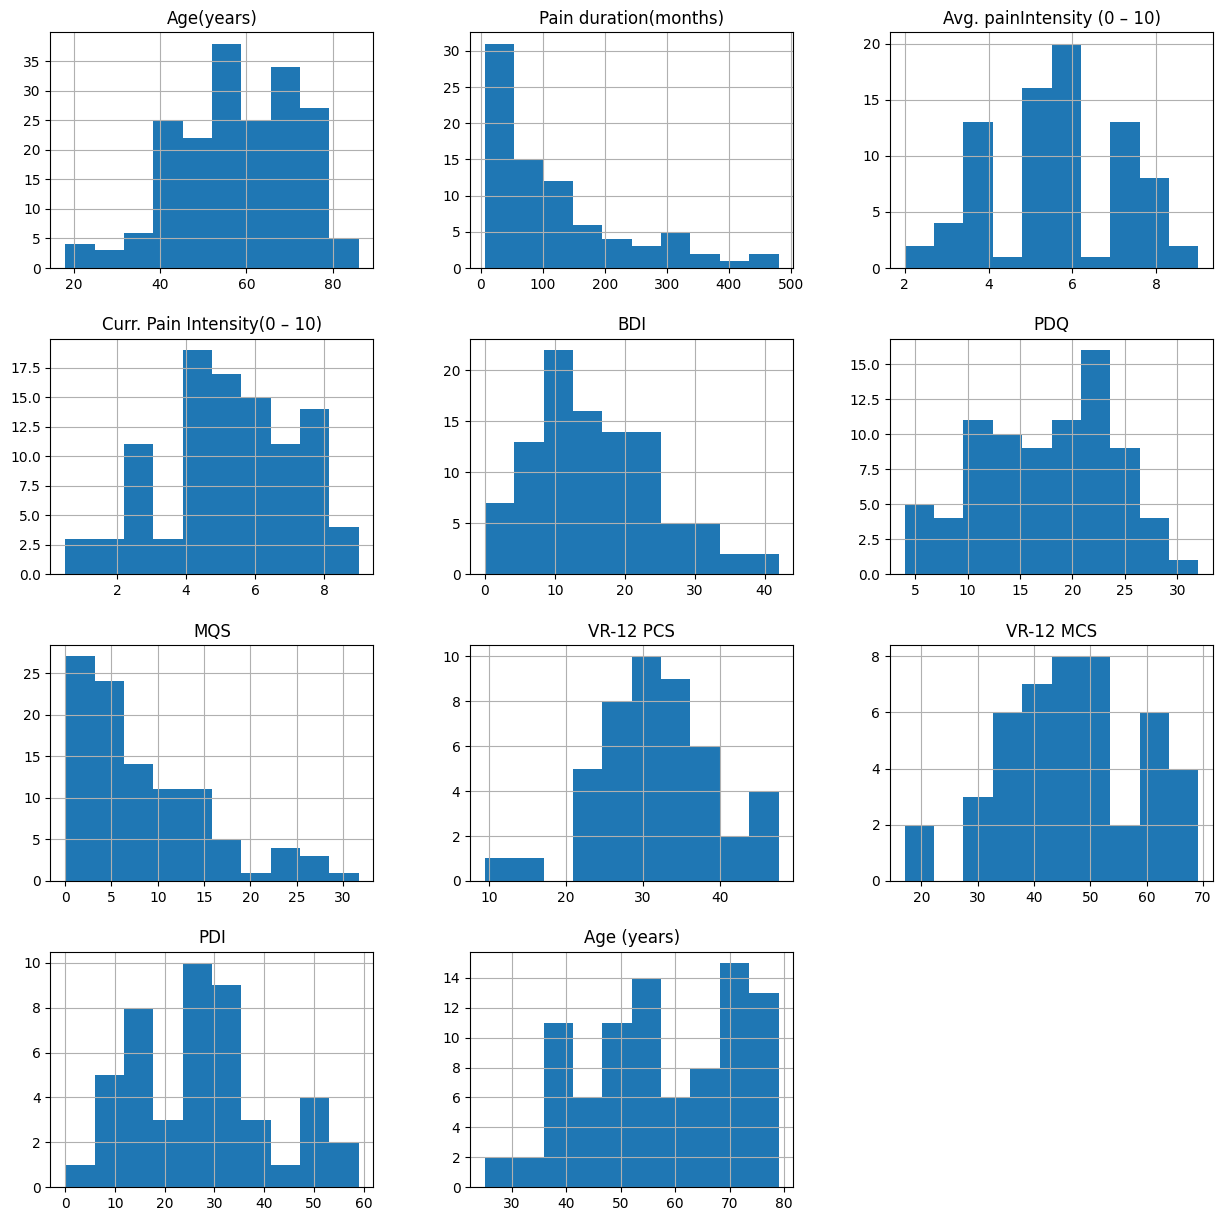

In [17]:
df_subj.hist(figsize=(15,15))

#### Sex imbalance: more women among patients

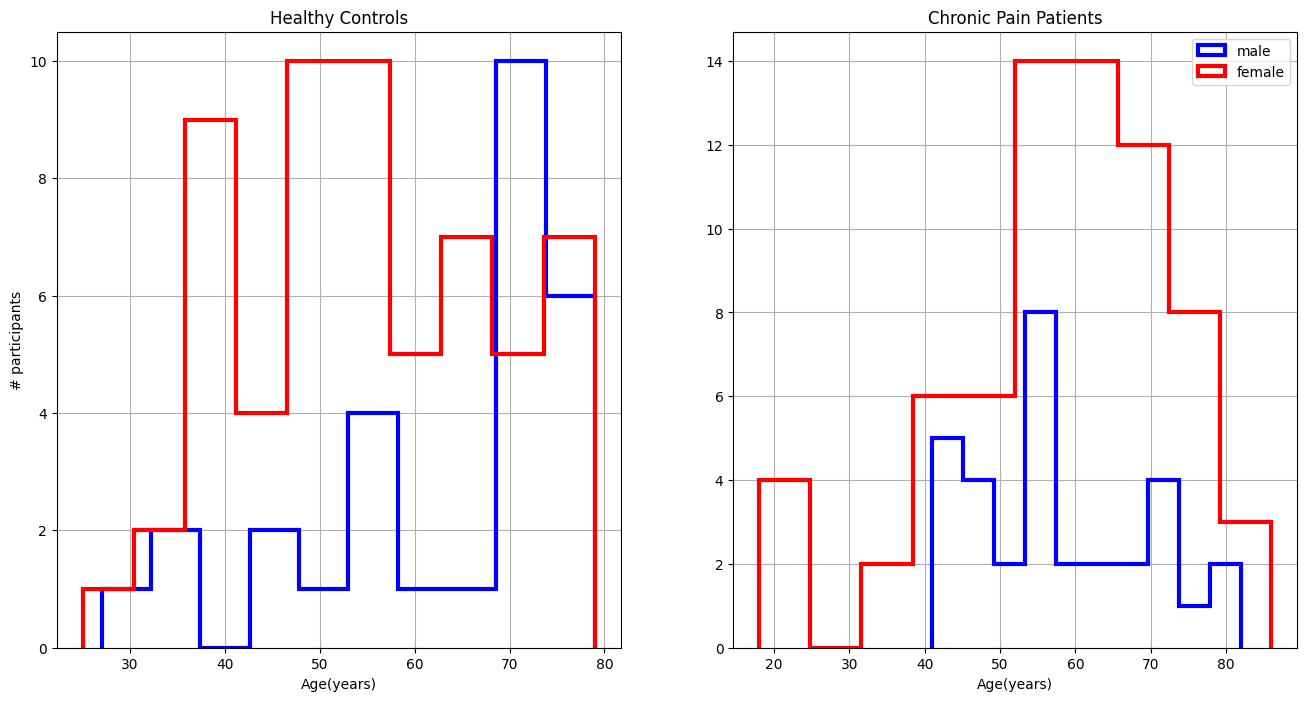

In [18]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("Healthy Controls")
df_subj_healthy[df_subj_healthy["Sex (m/f)"]=="m"]["Age (years)"].hist(
    histtype="step", label="male", color="b", linewidth=3, density=False)
df_subj_healthy[df_subj_healthy["Sex (m/f)"]=="f"]["Age (years)"].hist(
    histtype="step", label="female", color="r", linewidth=3, density=False)
plt.ylabel("# participants")
plt.xlabel("Age(years)")

plt.subplot(1,2,2)
plt.title("Chronic Pain Patients")
df_subj_chronic_pain[df_subj_chronic_pain["Sex (m/f)"]=="m"]["Age(years)"].hist(
    histtype="step", label="male", color="b", linewidth=3, density=False)
df_subj_chronic_pain[df_subj_chronic_pain["Sex (m/f)"]=="f"]["Age(years)"].hist(
    histtype="step", label="female", color="r", linewidth=3, density=False)
plt.xlabel("Age(years)")
plt.legend()


#### Plot age distributions for every clinical condition and sex

In men, some ages are not represented

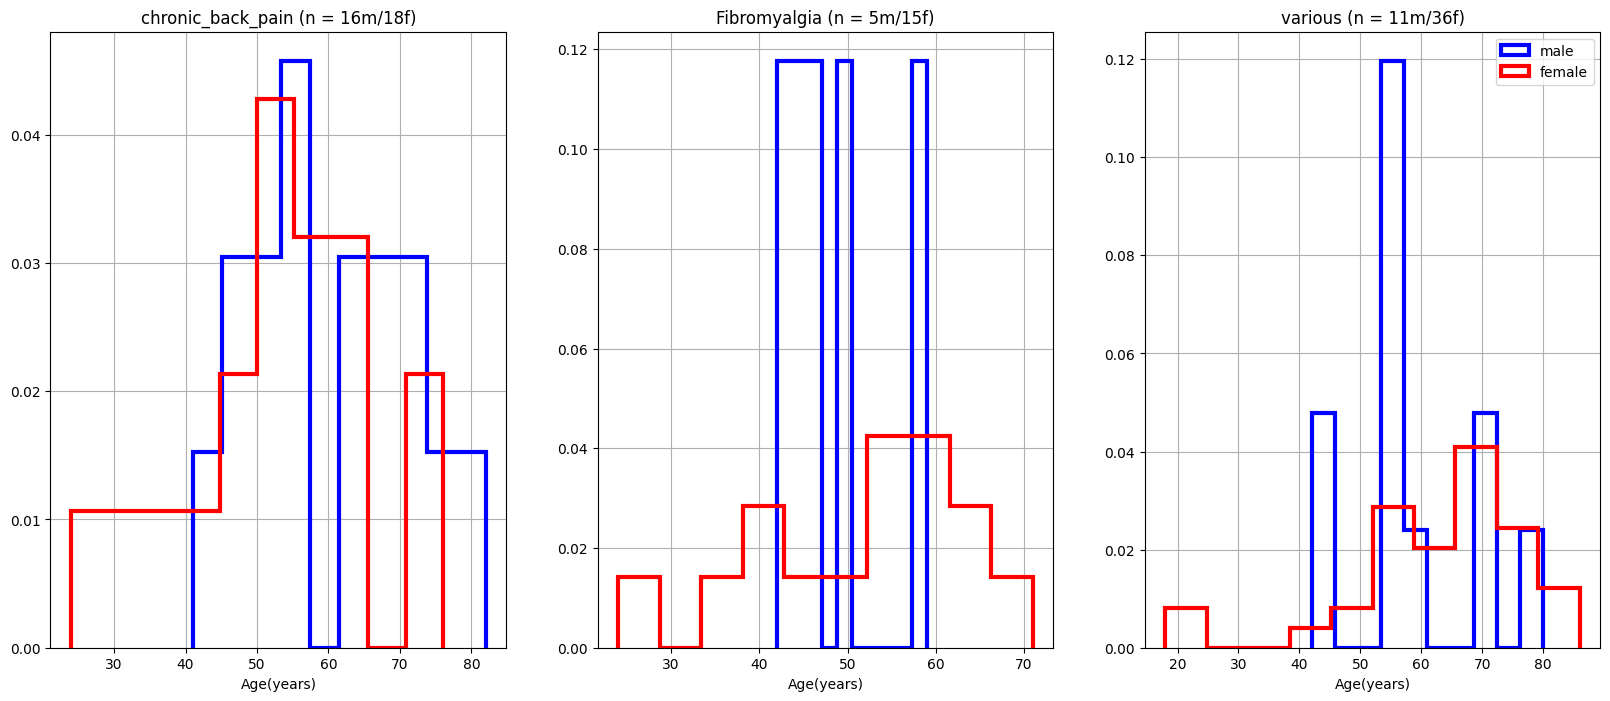

In [19]:
conditions = df_subj_chronic_pain["Project prefix"].unique()

plt.figure(figsize=(20,8))

for i, condition in enumerate(conditions):
    plt.subplot(1,3,i+1)
    
    df_subj_by_cond = df_subj_chronic_pain[df_subj_chronic_pain["Project prefix"]==condition]
    is_male = df_subj_by_cond["Sex (m/f)"]=="m"
    is_female = is_male.map(lambda x: not x)
    
    plt.title(f"{condition} (n = {is_male.sum()}m/{is_female.sum()}f)")
    df_subj_by_cond[is_male]["Age(years)"].hist(
        histtype="step", label="male", color="b", linewidth=3, density=True)
    df_subj_by_cond[is_female]["Age(years)"].hist(
        histtype="step", label="female", color="r", linewidth=3, density=True)
    plt.xlabel("Age(years)")
    
plt.legend()

#### Plot age distributions for every clinical condition

The age distribution is similar across clinical conditions

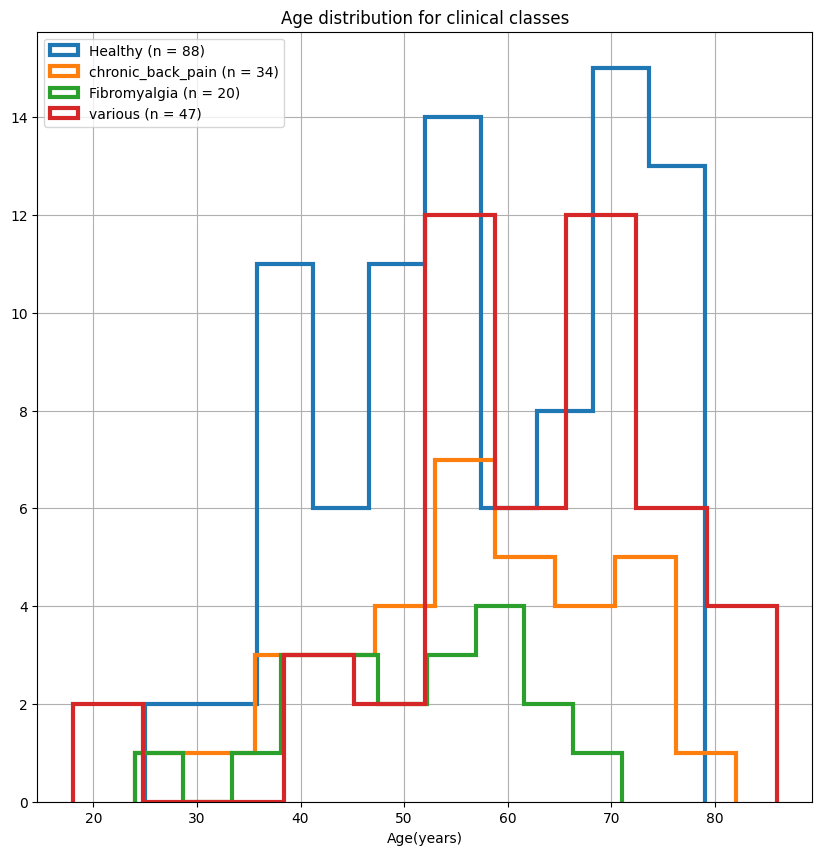

In [20]:
conditions = df_subj_chronic_pain["Project prefix"].unique()


plt.figure(figsize=(10,10))
plt.title("Age distribution for clinical classes")

df_subj_healthy["Age (years)"].hist(
    histtype="step", label=f"Healthy (n = {len(df_subj_healthy)})", linewidth=3, density=False)


for i, condition in enumerate(conditions):
    
    df_subj_by_cond = df_subj_chronic_pain[df_subj_chronic_pain["Project prefix"]==condition]
    
    df_subj_by_cond["Age(years)"].hist(
        histtype="step", label=f"{condition} (n = {len(df_subj_by_cond)})", linewidth=3, density=False)
    plt.xlabel("Age(years)")


plt.legend()

array([[<Axes: xlabel='Age(years)', ylabel='Age(years)'>,
        <Axes: xlabel='Pain duration(months)', ylabel='Age(years)'>,
        <Axes: xlabel='Avg. painIntensity (0 – 10)', ylabel='Age(years)'>,
        <Axes: xlabel='Curr. Pain Intensity(0 – 10)', ylabel='Age(years)'>,
        <Axes: xlabel='BDI', ylabel='Age(years)'>,
        <Axes: xlabel='PDQ', ylabel='Age(years)'>,
        <Axes: xlabel='MQS', ylabel='Age(years)'>,
        <Axes: xlabel='VR-12 PCS', ylabel='Age(years)'>,
        <Axes: xlabel='VR-12 MCS', ylabel='Age(years)'>,
        <Axes: xlabel='PDI', ylabel='Age(years)'>,
        <Axes: xlabel='Age (years)', ylabel='Age(years)'>],
       [<Axes: xlabel='Age(years)', ylabel='Pain duration(months)'>,
        <Axes: xlabel='Pain duration(months)', ylabel='Pain duration(months)'>,
        <Axes: xlabel='Avg. painIntensity (0 – 10)', ylabel='Pain duration(months)'>,
        <Axes: xlabel='Curr. Pain Intensity(0 – 10)', ylabel='Pain duration(months)'>,
        <Axes: xlabel=

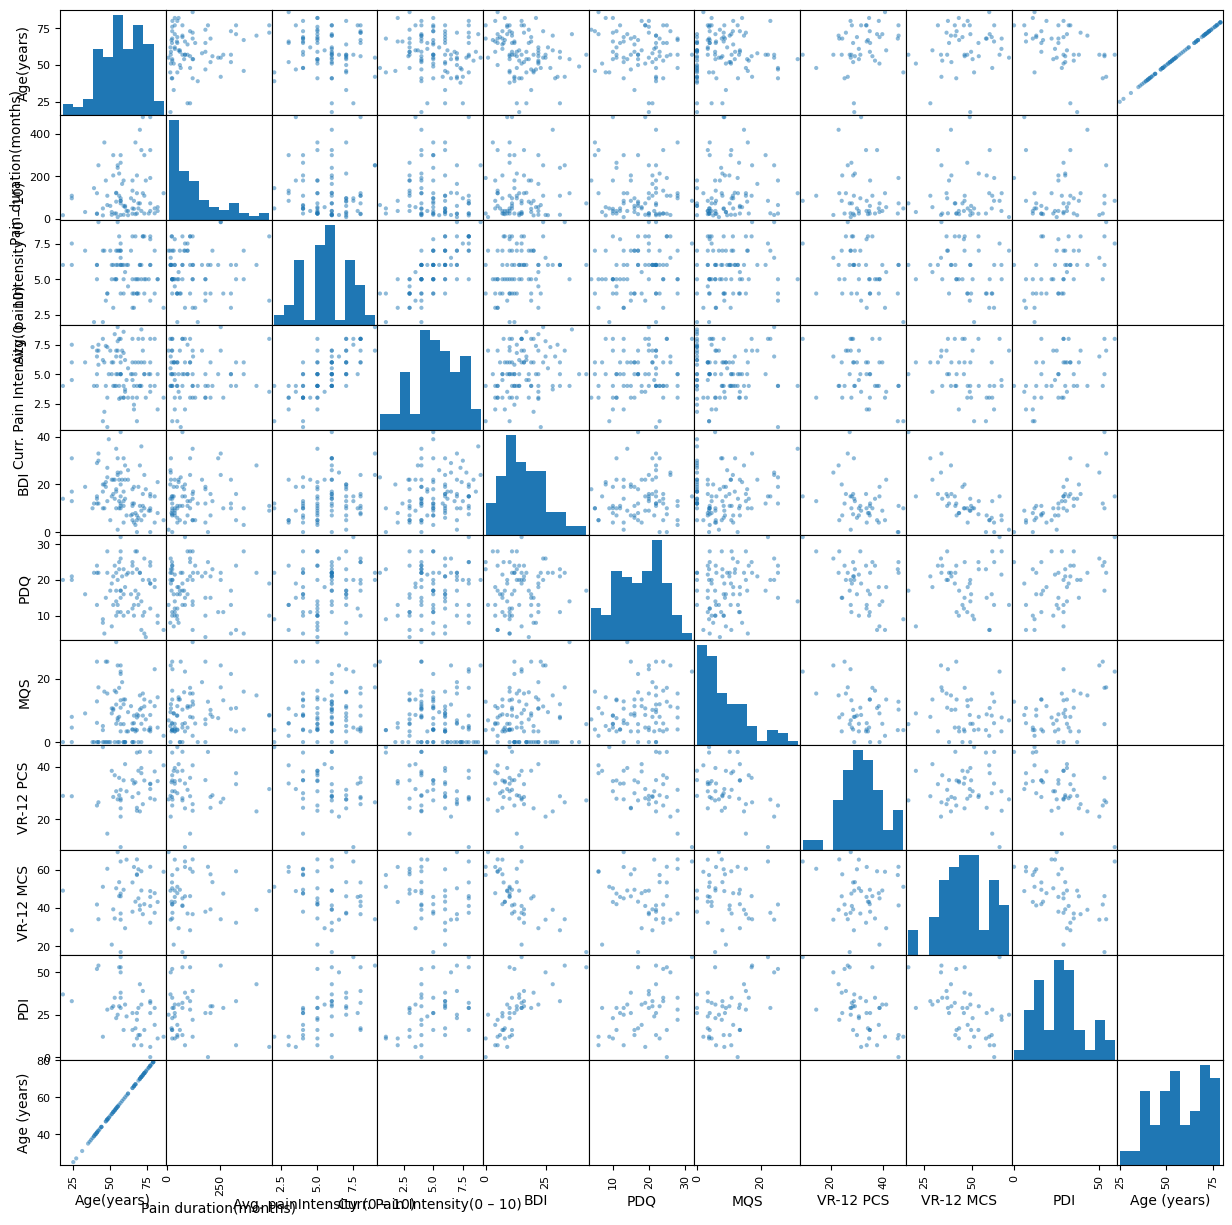

In [21]:
pd.plotting.scatter_matrix(df_subj, figsize=(15,15))

### Analyze a single eeg file

#### Load the file

In [22]:
example_raw = mne.io.read_raw_brainvision(eeg_files_chronic_pain[0])
channel_to_channel_type = {ch_name:"eeg" for ch_name in example_raw.ch_names}
channel_to_channel_type.update({"LE":"misc", "RE":"misc"})
example_raw.set_channel_types(channel_to_channel_type)

Extracting parameters from ../../data/chronic_pain_patients/chronic_back_pain/preprocessed/Exp_eyes_closed_vp11_eyes_closed.vhdr...
Setting channel info structure...


/tmp/ipykernel_2508598/74198812.py:1: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  example_raw = mne.io.read_raw_brainvision(eeg_files_chronic_pain[0])
/tmp/ipykernel_2508598/74198812.py:1: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1'

<RawBrainVision | Exp_eyes_closed_vp11_eyes_closed.dat, 65 x 300004 (300.0 s), ~71 kB, data not loaded>

#### Check the metadata

In [23]:
example_raw

<RawBrainVision | Exp_eyes_closed_vp11_eyes_closed.dat, 65 x 300004 (300.0 s), ~71 kB, data not loaded>

#### Plot the locations of the eeg sensors on the head

Find a montage that fits our data

In [24]:
for montage_name in mne.channels.get_builtin_montages():
    montage = mne.channels.make_standard_montage(montage_name)
    n_common_chs = len(set(example_raw.ch_names).intersection(set(montage.ch_names)))
    print(
        f"montage: {montage_name} \
        \nn_common_chs out of {len(montage.ch_names)}: {n_common_chs} \
        \n==================")

montage: standard_1005         
n_common_chs out of 343: 63         
montage: standard_1020         
n_common_chs out of 94: 63         
montage: standard_alphabetic         
n_common_chs out of 65: 27         
montage: standard_postfixed         
n_common_chs out of 100: 28         
montage: standard_prefixed         
n_common_chs out of 74: 28         
montage: standard_primed         
n_common_chs out of 100: 28         
montage: biosemi16         
n_common_chs out of 16: 16         
montage: biosemi32         
n_common_chs out of 32: 32         
montage: biosemi64         
n_common_chs out of 64: 57         
montage: biosemi128         
n_common_chs out of 128: 6         
montage: biosemi160         
n_common_chs out of 160: 6         
montage: biosemi256         
n_common_chs out of 256: 12         
montage: easycap-M1         
n_common_chs out of 74: 63         
montage: easycap-M10         
n_common_chs out of 61: 0         
montage: EGI_256         
n_common_chs out of 256: 0  

Set the montage

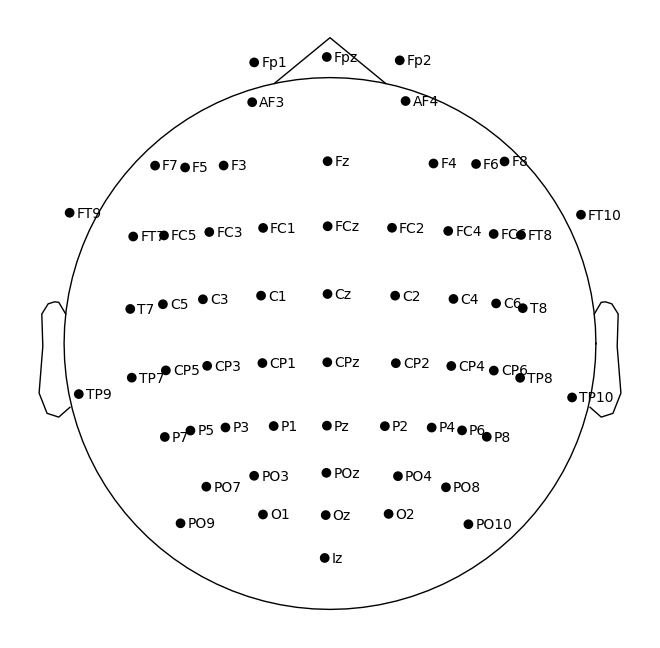

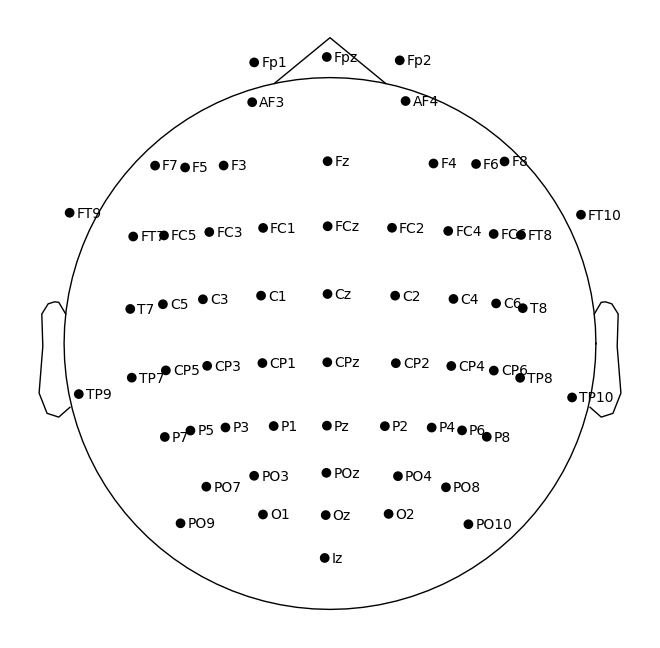

In [25]:
montage = mne.channels.make_standard_montage("standard_1020")
set(example_raw.ch_names) - set(montage.ch_names), \
set(montage.ch_names) - set(example_raw.ch_names)
example_raw = example_raw.set_montage(montage)
example_raw.plot_sensors(show_names=True)

#### Visualize a the time and frequency domain

Using matplotlib as 2D backend.


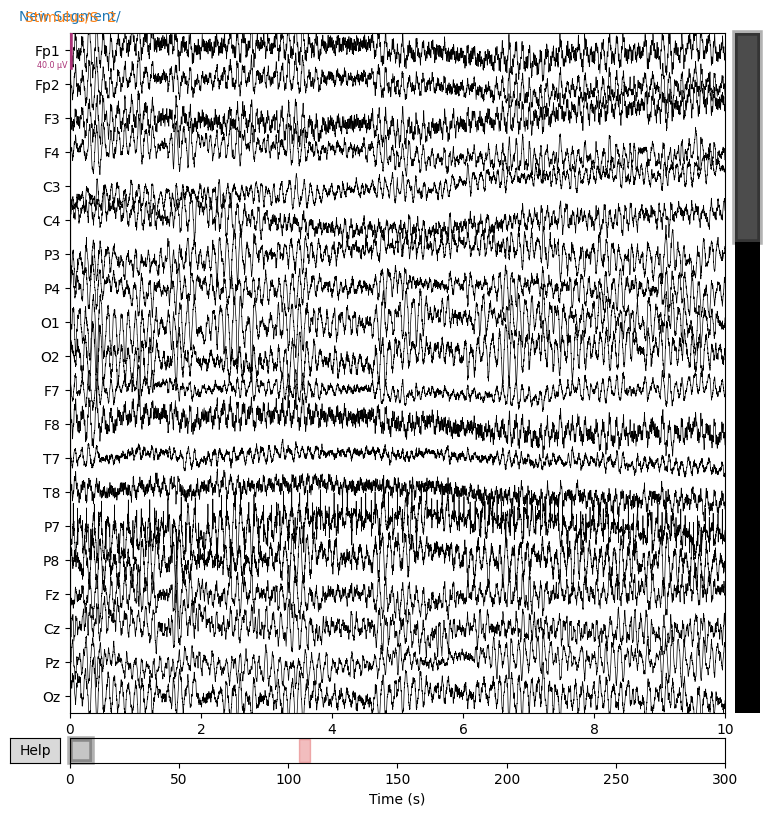

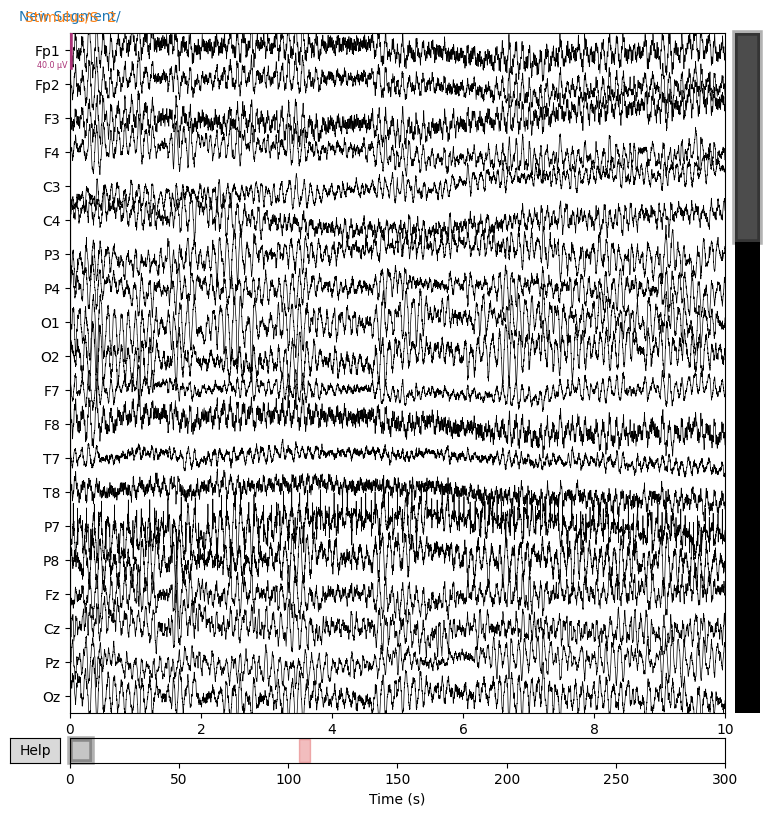

In [26]:
example_raw.plot()

#### Visualize the frequency domain

Setting 5179 of 300004 (1.73%) samples to NaN, retaining 294825 (98.27%) samples.
Effective window size : 0.256 (s)


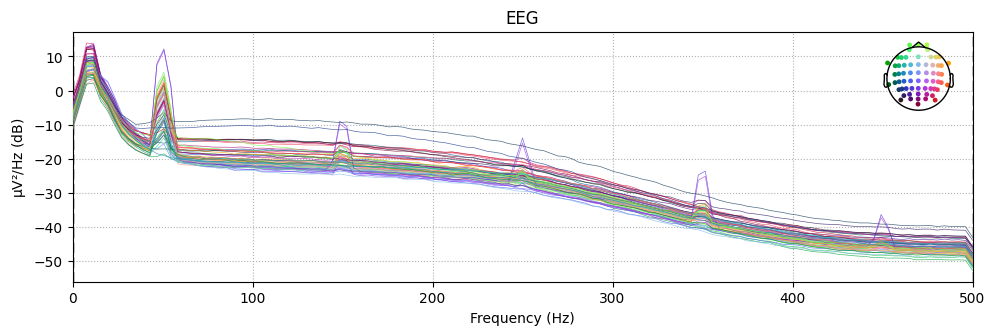

In [27]:
example_raw.compute_psd().plot()

Setting 5179 of 300004 (1.73%) samples to NaN, retaining 294825 (98.27%) samples.
Effective window size : 0.256 (s)


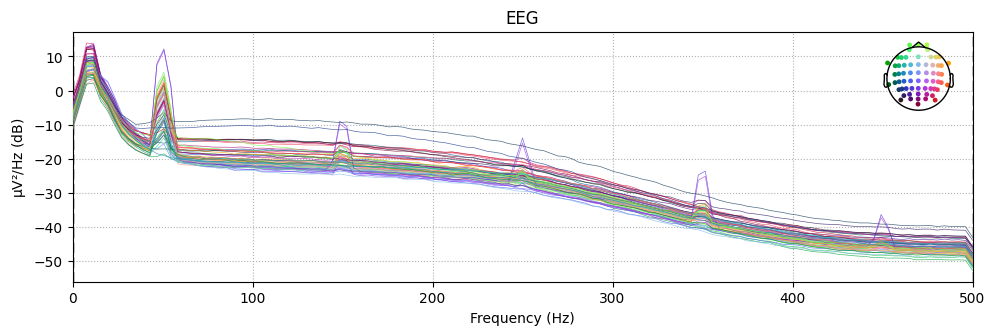

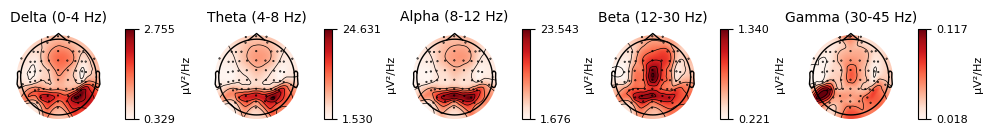

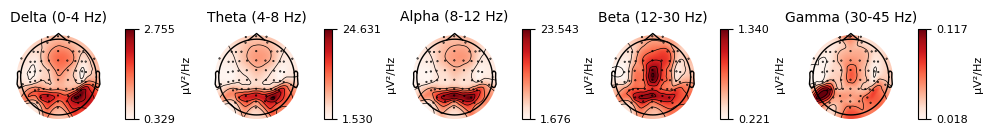

In [28]:
example_raw.compute_psd().plot_topomap()

### Analyze all files with respect to age

In [29]:
def get_subj_id(eeg_file: pathlib.Path):
    return eeg_file.stem.split("_")[-3]

def get_age(df_subj, eeg_file: pathlib.Path):
    subj_id = get_subj_id(eeg_file)
    return df_subj[df_subj["Subject ID"] == subj_id]["Age(years)"]
    

#### Color PSDs by age

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'F

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/2264468600.py:10: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1

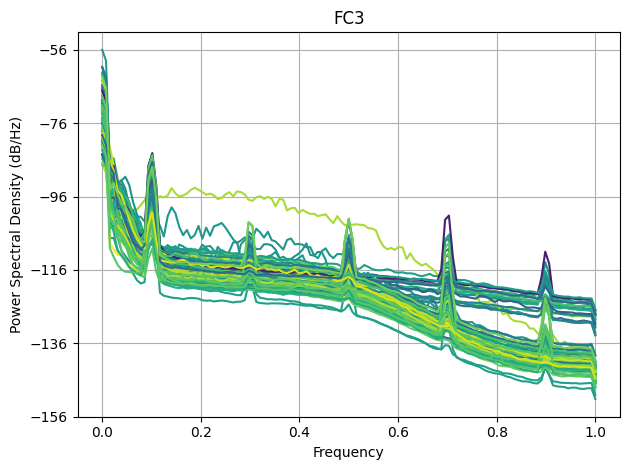

In [30]:
chs_pick = np.random.choice(example_raw.ch_names, replace=False, size=1)

c_scale = 1
min_age = df_subj["Age(years)"].min()
max_age = df_subj["Age(years)"].max()

np.random.shuffle(eeg_files_chronic_pain)
for f in eeg_files_chronic_pain:
    age = get_age(df_subj, f).values[0]
    raw = mne.io.read_raw_brainvision(f, verbose=False)
    
    for i, ch_pick in enumerate(chs_pick):
        raw_data = raw.get_data(ch_pick, verbose=False)[0]
        plt.title(ch_pick)
        plt.subplot(1, len(chs_pick), i+1)
        c_idx = c_scale*(age-min_age)/(max_age-min_age)
        plt.psd(raw_data, color=mpl.colormaps["viridis"](c_idx))
# plt.colorbar()
plt.tight_layout()
plt.show()
    

In [31]:
psds_healthy = []
ages_healthy = []
psds_chronic_pain = []
ages_chronic_pain = []
for f in eeg_files_preprocessed:
    age = get_age(df_subj, f).values[0]
    raw = mne.io.read_raw_brainvision(f, verbose=False)
    raw = raw.set_channel_types(channel_to_channel_type, verbose=False)
    
    if df_subj[df_subj["Subject ID"] == get_subj_id(f)]["Pain duration(months)"].isnull().item():
        ages_healthy.append(age)
        psds_healthy.append(raw.compute_psd().get_data())
    else:
        ages_chronic_pain.append(age)
        psds_chronic_pain.append(raw.compute_psd().get_data())
    
psds_healthy = np.stack(psds_healthy)
ages_healthy = np.array(ages_healthy)

psds_chronic_pain = np.stack(psds_chronic_pain)
ages_chronic_pain = np.array(ages_chronic_pain)

Setting 5179 of 300004 (1.73%) samples to NaN, retaining 294825 (98.27%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3312 of 300003 (1.10%) samples to NaN, retaining 296691 (98.90%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 31847 of 300004 (10.62%) samples to NaN, retaining 268157 (89.38%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2655 of 300004 (0.88%) samples to NaN, retaining 297349 (99.12%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 25563 of 300004 (8.52%) samples to NaN, retaining 274441 (91.48%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7089 of 300003 (2.36%) samples to NaN, retaining 292914 (97.64%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 11651 of 300004 (3.88%) samples to NaN, retaining 288353 (96.12%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 8806 of 300003 (2.94%) samples to NaN, retaining 291197 (97.06%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10173 of 300002 (3.39%) samples to NaN, retaining 289829 (96.61%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 803 of 300005 (0.27%) samples to NaN, retaining 299202 (99.73%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4314 of 300003 (1.44%) samples to NaN, retaining 295689 (98.56%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6474 of 300004 (2.16%) samples to NaN, retaining 293530 (97.84%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 14629 of 300003 (4.88%) samples to NaN, retaining 285374 (95.12%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 15604 of 300004 (5.20%) samples to NaN, retaining 284400 (94.80%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 545 of 300005 (0.18%) samples to NaN, retaining 299460 (99.82%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1211 of 300002 (0.40%) samples to NaN, retaining 298791 (99.60%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7235 of 300004 (2.41%) samples to NaN, retaining 292769 (97.59%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6700 of 300003 (2.23%) samples to NaN, retaining 293303 (97.77%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10083 of 300004 (3.36%) samples to NaN, retaining 289921 (96.64%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10228 of 300005 (3.41%) samples to NaN, retaining 289777 (96.59%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 23800 of 300004 (7.93%) samples to NaN, retaining 276204 (92.07%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7635 of 300001 (2.54%) samples to NaN, retaining 292366 (97.46%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10545 of 300001 (3.51%) samples to NaN, retaining 289456 (96.49%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 13462 of 300004 (4.49%) samples to NaN, retaining 286542 (95.51%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 641 of 300005 (0.21%) samples to NaN, retaining 299364 (99.79%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 401 of 300003 (0.13%) samples to NaN, retaining 299602 (99.87%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 8659 of 300004 (2.89%) samples to NaN, retaining 291345 (97.11%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1501 of 300004 (0.50%) samples to NaN, retaining 298503 (99.50%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 15704 of 300004 (5.23%) samples to NaN, retaining 284300 (94.77%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3032 of 300005 (1.01%) samples to NaN, retaining 296973 (98.99%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7217 of 300003 (2.41%) samples to NaN, retaining 292786 (97.59%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5861 of 300006 (1.95%) samples to NaN, retaining 294145 (98.05%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 9655 of 300002 (3.22%) samples to NaN, retaining 290347 (96.78%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 19558 of 300006 (6.52%) samples to NaN, retaining 280448 (93.48%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 950 of 300003 (0.32%) samples to NaN, retaining 299053 (99.68%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 920 of 300001 (0.31%) samples to NaN, retaining 299081 (99.69%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 15388 of 300002 (5.13%) samples to NaN, retaining 284614 (94.87%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 30195 of 300004 (10.06%) samples to NaN, retaining 269809 (89.94%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 26827 of 300005 (8.94%) samples to NaN, retaining 273178 (91.06%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 1675 of 300004 (0.56%) samples to NaN, retaining 298329 (99.44%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1488 of 300006 (0.50%) samples to NaN, retaining 298518 (99.50%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1611 of 300003 (0.54%) samples to NaN, retaining 298392 (99.46%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2289 of 300002 (0.76%) samples to NaN, retaining 297713 (99.24%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5166 of 300002 (1.72%) samples to NaN, retaining 294836 (98.28%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4198 of 300005 (1.40%) samples to NaN, retaining 295807 (98.60%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4945 of 300006 (1.65%) samples to NaN, retaining 295061 (98.35%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10042 of 300003 (3.35%) samples to NaN, retaining 289961 (96.65%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 6540 of 302540 (2.16%) samples to NaN, retaining 296000 (97.84%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 6853 of 301800 (2.27%) samples to NaN, retaining 294947 (97.73%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 2870 of 302200 (0.95%) samples to NaN, retaining 299330 (99.05%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 5380 of 313220 (1.72%) samples to NaN, retaining 307840 (98.28%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 40974 of 311620 (13.15%) samples to NaN, retaining 270646 (86.85%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3941 of 302460 (1.30%) samples to NaN, retaining 298519 (98.70%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3186 of 307040 (1.04%) samples to NaN, retaining 303854 (98.96%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3856 of 328280 (1.17%) samples to NaN, retaining 324424 (98.83%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 11506 of 301600 (3.81%) samples to NaN, retaining 290094 (96.19%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 2753 of 301320 (0.91%) samples to NaN, retaining 298567 (99.09%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 7440 of 299000 (2.49%) samples to NaN, retaining 291560 (97.51%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 10945 of 306960 (3.57%) samples to NaN, retaining 296015 (96.43%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 15697 of 351760 (4.46%) samples to NaN, retaining 336063 (95.54%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 806 of 362500 (0.22%) samples to NaN, retaining 361694 (99.78%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7462 of 344240 (2.17%) samples to NaN, retaining 336778 (97.83%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 16360 of 303100 (5.40%) samples to NaN, retaining 286740 (94.60%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3489 of 314440 (1.11%) samples to NaN, retaining 310951 (98.89%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1215 of 301480 (0.40%) samples to NaN, retaining 300265 (99.60%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 803 of 335280 (0.24%) samples to NaN, retaining 334477 (99.76%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 500 of 300005 (0.17%) samples to NaN, retaining 299505 (99.83%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2187 of 309680 (0.71%) samples to NaN, retaining 307493 (99.29%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5924 of 300004 (1.97%) samples to NaN, retaining 294080 (98.03%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 500 of 300004 (0.17%) samples to NaN, retaining 299504 (99.83%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 20123 of 300002 (6.71%) samples to NaN, retaining 279879 (93.29%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2583 of 300003 (0.86%) samples to NaN, retaining 297420 (99.14%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7985 of 300003 (2.66%) samples to NaN, retaining 292018 (97.34%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 13141 of 300002 (4.38%) samples to NaN, retaining 286861 (95.62%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1954 of 300001 (0.65%) samples to NaN, retaining 298047 (99.35%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4821 of 312120 (1.54%) samples to NaN, retaining 307299 (98.46%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1000 of 300005 (0.33%) samples to NaN, retaining 299005 (99.67%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7875 of 301140 (2.62%) samples to NaN, retaining 293265 (97.38%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4473 of 304460 (1.47%) samples to NaN, retaining 299987 (98.53%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7270 of 300005 (2.42%) samples to NaN, retaining 292735 (97.58%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5269 of 300001 (1.76%) samples to NaN, retaining 294732 (98.24%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2820 of 300260 (0.94%) samples to NaN, retaining 297440 (99.06%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5461 of 300480 (1.82%) samples to NaN, retaining 295019 (98.18%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2970 of 300002 (0.99%) samples to NaN, retaining 297032 (99.01%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1720 of 317028 (0.54%) samples to NaN, retaining 315308 (99.46%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 8655 of 300006 (2.88%) samples to NaN, retaining 291351 (97.12%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3901 of 300005 (1.30%) samples to NaN, retaining 296104 (98.70%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 20193 of 336900 (5.99%) samples to NaN, retaining 316707 (94.01%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 4089 of 300002 (1.36%) samples to NaN, retaining 295913 (98.64%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1500 of 300002 (0.50%) samples to NaN, retaining 298502 (99.50%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6243 of 300000 (2.08%) samples to NaN, retaining 293757 (97.92%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2430 of 301540 (0.81%) samples to NaN, retaining 299110 (99.19%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2850 of 300440 (0.95%) samples to NaN, retaining 297590 (99.05%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3276 of 301340 (1.09%) samples to NaN, retaining 298064 (98.91%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7882 of 300003 (2.63%) samples to NaN, retaining 292121 (97.37%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2771 of 300003 (0.92%) samples to NaN, retaining 297232 (99.08%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4825 of 300920 (1.60%) samples to NaN, retaining 296095 (98.40%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 29656 of 302740 (9.80%) samples to NaN, retaining 273084 (90.20%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 5033 of 300004 (1.68%) samples to NaN, retaining 294971 (98.32%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 758 of 300004 (0.25%) samples to NaN, retaining 299246 (99.75%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 13901 of 300005 (4.63%) samples to NaN, retaining 286104 (95.37%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1349 of 300005 (0.45%) samples to NaN, retaining 298656 (99.55%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 14219 of 361960 (3.93%) samples to NaN, retaining 347741 (96.07%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 10102 of 314661 (3.21%) samples to NaN, retaining 304559 (96.79%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 8159 of 307900 (2.65%) samples to NaN, retaining 299741 (97.35%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 48676 of 300002 (16.23%) samples to NaN, retaining 251326 (83.77%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 2099 of 300004 (0.70%) samples to NaN, retaining 297905 (99.30%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 1633 of 300002 (0.54%) samples to NaN, retaining 298369 (99.46%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6253 of 320540 (1.95%) samples to NaN, retaining 314287 (98.05%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6068 of 300005 (2.02%) samples to NaN, retaining 293937 (97.98%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 7925 of 300004 (2.64%) samples to NaN, retaining 292079 (97.36%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 11462 of 300004 (3.82%) samples to NaN, retaining 288542 (96.18%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 3593 of 300001 (1.20%) samples to NaN, retaining 296408 (98.80%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 49058 of 300004 (16.35%) samples to NaN, retaining 250946 (83.65%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 17660 of 300006 (5.89%) samples to NaN, retaining 282346 (94.11%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 14597 of 361800 (4.03%) samples to NaN, retaining 347203 (95.97%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 3188 of 300005 (1.06%) samples to NaN, retaining 296817 (98.94%) samples.


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)
Setting 2266 of 300002 (0.76%) samples to NaN, retaining 297736 (99.24%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:8: RuntimeWarning: The unit for channel(s) LE, RE has changed from V to NA.
  raw = raw.set_channel_types(channel_to_channel_type, verbose=False)


Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 4724 of 300004 (1.57%) samples to NaN, retaining 295280 (98.43%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 6254 of 300002 (2.08%) samples to NaN, retaining 293748 (97.92%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 7592 of 300003 (2.53%) samples to NaN, retaining 292411 (97.47%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 11012 of 300003 (3.67%) samples to NaN, retaining 288991 (96.33%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 43283 of 300001 (14.43%) samples to NaN, retaining 256718 (85.57%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.


/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: No coordinate information found for channels ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(f, verbose=False)
/tmp/ipykernel_2508598/3462009345.py:7: RuntimeWarning: Not setting positions of 64 misc channels found in montage:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'LE', 'RE', 'P1', 'P2', 'C1',

Effective window size : 0.256 (s)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [33]:
ch_name_to_ch_pos = montage.get_positions()["ch_pos"]

pos = [ch_name_to_ch_pos[ch_name] for ch_name in example_raw.ch_names if channel_to_channel_type[ch_name]=="eeg"]
pos = np.stack(pos)

Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052

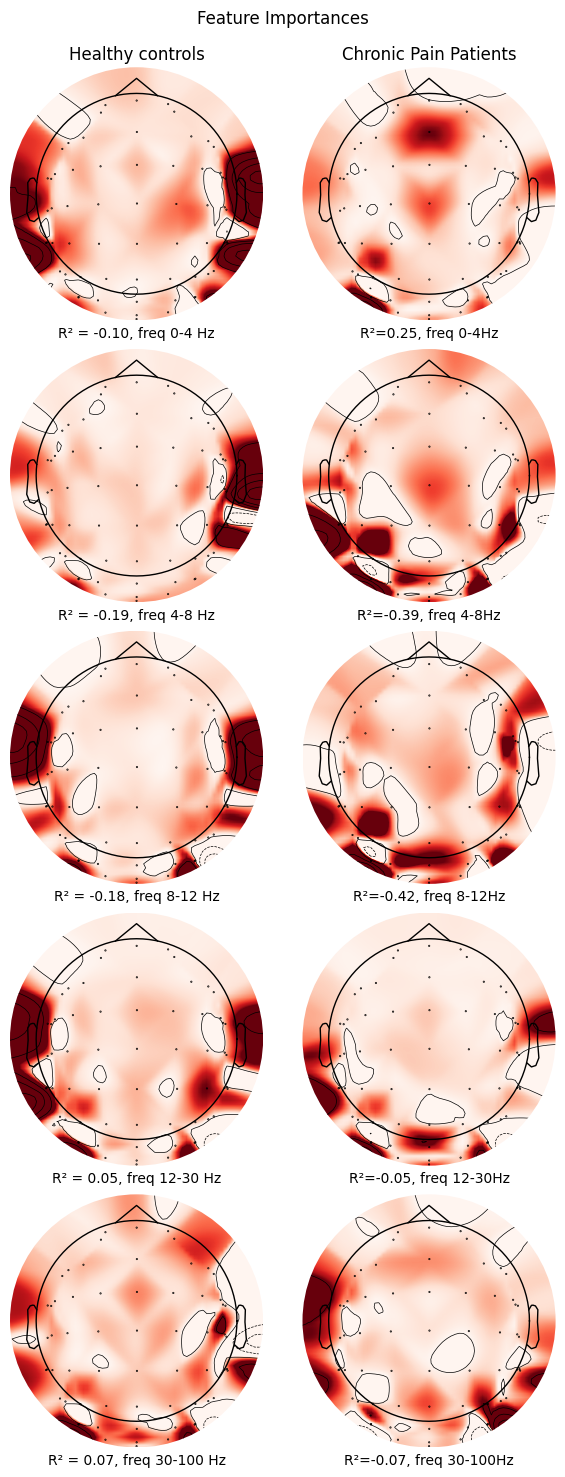

In [35]:
# band_size = 20
# band_sections = np.arange(band_size, 120, band_size)
band_sections = [4,8,12,30,100]
# freq_bands = np.split(psds, band_sections, axis=-1)[:-1]

fig, ax = plt.subplots(len(band_sections), 2 , figsize=(6,15))
plt.suptitle("Feature Importances\n")

l_freq = 0
for i in range(len(band_sections)):


    h_freq = band_sections[i]
    is_band = (raw.compute_psd().freqs > l_freq) * \
              (raw.compute_psd().freqs < h_freq)

    X, y = psds_healthy[:, :, is_band].sum(-1), ages_healthy
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    rfg = RandomForestRegressor()
    rfg.fit(X_train, y_train)
    r_squared = rfg.score(scaler.transform(X_test), y_test)

    ax[0,0].set_title("Healthy controls") if i == 0 else _
    ax[i,0].set_xlabel(f"R² = {r_squared:.2f}, freq {l_freq}-{h_freq} Hz")
    mne.viz.plot_topomap(rfg.feature_importances_, pos[:, :2], axes=ax[i,0], show=False)
    l_freq = h_freq

l_freq = 0
for i in range(len(band_sections)):


    h_freq = band_sections[i]
    is_band = (raw.compute_psd().freqs > l_freq) * \
              (raw.compute_psd().freqs < h_freq)

    X, y = psds_chronic_pain[:, :, is_band].sum(-1), ages_chronic_pain
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    rfg = RandomForestRegressor()
    rfg.fit(X_train, y_train)
    r_squared = rfg.score(scaler.transform(X_test), y_test)

    ax[0,1].set_title("Chronic Pain Patients") if i == 0 else _
    ax[i,1].set_xlabel(f"R²={r_squared:.2f}, freq {l_freq}-{h_freq}Hz")
    mne.viz.plot_topomap(rfg.feature_importances_, pos[:, :2], axes=ax[i,1], show=False)
    l_freq = h_freq

    
plt.tight_layout()
plt.show()

Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052 (96.74%) samples.
Effective window size : 0.256 (s)
Setting 15348 of 471400 (3.26%) samples to NaN, retaining 456052

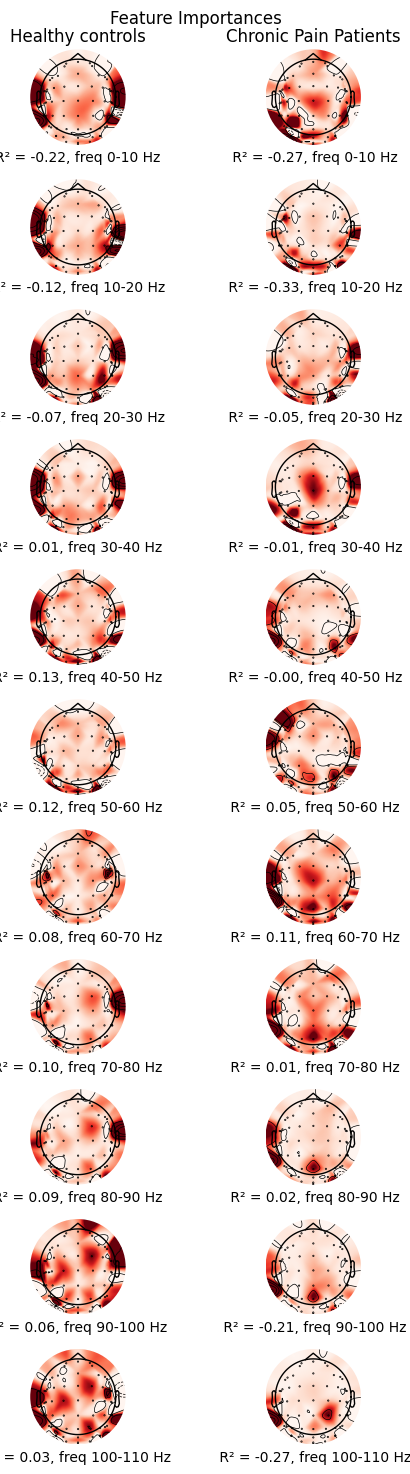

In [123]:
band_size = 20
band_sections = np.arange(band_size, 120, band_size)
# freq_bands = np.split(psds, band_sections, axis=-1)[:-1]

fig, ax = plt.subplots(len(band_sections), 2 , figsize=(6,15))
plt.suptitle("Feature Importances")

l_freq = 0
for i in range(len(band_sections)):


    h_freq = band_sections[i]
    is_band = (raw.compute_psd().freqs > l_freq) * \
              (raw.compute_psd().freqs < h_freq)

    X, y = psds_healthy[:, :, is_band].sum(-1), ages_healthy
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    rfg = RandomForestRegressor()
    rfg.fit(X_train, y_train)
    r_squared = rfg.score(scaler.transform(X_test), y_test)

    ax[0,0].set_title("Healthy controls") if i == 0 else _
    ax[i,0].set_xlabel(f"R² = {r_squared:.2f}, freq {l_freq}-{h_freq} Hz")
    mne.viz.plot_topomap(rfg.feature_importances_, pos[:, :2], axes=ax[i,0], show=False)
    l_freq = h_freq

l_freq = 0
for i in range(len(band_sections)):


    h_freq = band_sections[i]
    is_band = (raw.compute_psd().freqs > l_freq) * \
              (raw.compute_psd().freqs < h_freq)

    X, y = psds_chronic_pain[:, :, is_band].sum(-1), ages_chronic_pain
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    rfg = RandomForestRegressor()
    rfg.fit(X_train, y_train)
    r_squared = rfg.score(scaler.transform(X_test), y_test)

    ax[0,1].set_title("Chronic Pain Patients") if i == 0 else _
    ax[i,1].set_xlabel(f" R² = {r_squared:.2f}, freq {l_freq}-{h_freq} Hz")
    mne.viz.plot_topomap(rfg.feature_importances_, pos[:, :2], axes=ax[i,1], show=False)
    l_freq = h_freq

    
plt.tight_layout()
plt.show()